# Libraries
In order to run the code these are the requested libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.spatial.distance import cdist
import heapq
import time

# Random Point Generation

We generate a random set of n sparse points with label -1,1 and then we remove the label from 90% of them

In [2]:
def generate_sparse_points(n, seed, density=0.1):
    # Inputs:
    #   n (int): dimension of the matrix.
    #   seed (int): seed for the random generation.
    #   density (float): density for the generation of the sparse matrix.

    # Output:
    #   df (pd.DataFrame): a dataframe with columns ["x","y","label"] with x,y coordinates, label ["-1","1","None"].


    # Setting the seed for reproducibility
    np.random.seed(seed)
    
    # Randomly generate a sparse matrix
    A = sparse.random(n, n, density=density, random_state=seed)
    
    # Extract the coordinates from the non-zero elements
    rows, cols = A.nonzero()
    values = A.data
    
    # Map the class of data
    labels = np.where(values < 0.5, '-1', '1')
    
    # Randomly remove the label from 90% of data
    mask = np.random.rand(len(rows)) < 0.10
    labels = np.where(mask, labels, None)
    
    # Create the dataframe
    df = pd.DataFrame({'x': rows,'y': cols,'label': labels})
    
    return df

# Data Plot
Simple look at the distribution of the data

In [3]:
def plot_points(df):
    # Input:
    #   df (pd.DataFrame): a dataframe with columns ["x","y","label"] with x,y coordinates, label ["-1","1","None"].
    #Output:
    #   Visualize the distribution of the data with a simple plot.
    
    # Splitting the data into classes
    df_A = df[df['label'] == '1']
    df_B = df[df['label'] == '-1']
    df_unlabeled = df[df['label'].isna()]

    # Defining the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df_A['x'], df_A['y'], c='blue', label='Cluster 1', marker='o')
    plt.scatter(df_B['x'], df_B['y'], c='red', label='Cluster -1', marker='s')
    plt.scatter(df_unlabeled['x'], df_unlabeled['y'], c='gray', label='Unlabeled', marker='x')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Points Distribution')
    plt.legend()

    # Visualizing the plot
    plt.show()

# Objective Function Implementation

Code for the creation of the semi-supervised learning problem

In [4]:
def create_ssl_objective(df, sigma_w, sigma_bar_w, alpha=1e-6):
    # Inputs:
    #   df (pd.DataFrame): a dataframe with columns ["x","y","label"] with x,y coordinates, label ["-1","1","None"].
    #   sigma_w (float): Sigma for the Gaussian kernel between labelled - unlabelled points.
    #   sigma_bar_w (float): Sigma for the Gaussian kernel between unlabelled points.
    #   alpha (float, optional): Small value added to Q for stability.

    # Outputs:
    #   fast_updates_f (function): function for the fast updates of the objective function and the gradient
    #   safe_updates_f (function): function to compute the objective function and the gradient 
    #   Q (u,u): quadratic matrix of F(y) 
    #   b (u,): linear terms of the objective function

    # Dividing labelled and unlabelled data
    labelled_df = df[df['label'].notna()].copy()
    unlabelled_df = df[df['label'].isna()].copy()

    # Number of labelled points
    l = len(labelled_df) 
    # Number of unlabelled points
    u = len(unlabelled_df) 

    #Extracting coordinates and labels from each point
    labelled_points = labelled_df[['x', 'y']].values
    labelled_y_bar = labelled_df['label'].values.astype(float)
    unlabelled_points = unlabelled_df[['x', 'y']].values

    # The quadratic problem to minimize is F(y) = 0.5*y^T Q y + b^T y
    # We need to compute these terms

    # Calculating the weights w_ij (labelled i -> unlabelled j) 
    # The choosen distance measure is the squared euclidean distance
    # This distance is better than the euclidean distance because the derivative and the computation are simpler
    # We obtain a matrix with shape l x u where each element (i,j)=||w_i - x_j||^2
    dist_lu_sq = cdist(labelled_points, unlabelled_points, metric='sqeuclidean')

    # We need to transform the distance measure into a similarity between [0,1]
    # We use an RBF-Kernel to normalize each value in the matrix between 0 and 1 
    # More similar -> 1, more dissimilar values ->0
    W_lu = np.exp(-dist_lu_sq / (2 * sigma_w**2))

    # For each unlabelled point sum the weights of each labelled point
    # Represents how much each unlabelled point is related to all the labelled points
    sum_w_j = np.sum(W_lu, axis=0)

    # Building the diagonal matrix D_w with shape u x u 
    # We will use this matrix in the F(y), inside the Q term
    D_w = np.diag(sum_w_j)

    # Calculating the b term, a vector with shape (u,)
    # b_j = -2 * sum_i (w_ij * y_bar_i)
    b = -2 * W_lu.T @ labelled_y_bar 

    # Second term of the objective function -> similarity between unlabelled examples: 0.5 * sum w_bar_ij (yi - yj)^2 
    # Can be expanded in: sum_i (yi)^2 * (sum_{j!=i} w_bar_ij) - sum_{i, j!=i} w_bar_ij * yi * yj
    # Quadratic component: y^T * (D_smooth - W_smooth) * y
    # D_smooth is diagonal with D_smooth[i,i] = sum_{j!=i} w_bar_ij -> how a point is connected to the others
    # W_smooth weights matrix of w_bar_ij with diagonal 0 -> similarity between points
    # D_smooth - W_smooth -> penalize the difference between similar points

    # Calculating the weights w_bar_ij (unlabelled i -> unlabelled j) 
    # The choosen distance measure is the squared euclidean distance
    # This distance is better than the euclidean distance because the derivative and the computation are simpler
    # We obtain a matrix with shape u x u where each element (i,j)=||w_i - x_j||^2
    W_bar_uu = np.zeros((u, u))
    dist_uu_sq = cdist(unlabelled_points, unlabelled_points, metric='sqeuclidean')

    # We need to transform the distance measure into a similarity between [0,1]
    # We use an RBF-Kernel to normalize each value in the matrix between 0 and 1 
    # More similar -> 1, more dissimilar values ->0
    W_bar_uu = np.exp(-dist_uu_sq / (2 * sigma_bar_w**2))

    # We don't want any self loop similarity 
    np.fill_diagonal(W_bar_uu, 0)

    # Calculating D_smooth (grade matrix) diagonal matrix (u,u)
    # Sum the weight of each row, vector of dimension (u,) -> element i is the sum of similarity between point i and unlabelled j's
    D_smooth_diag = np.sum(W_bar_uu, axis=1)
    D_smooth = np.diag(D_smooth_diag)

    # The quadratic matrix for the second term is (D_smooth - W_bar_uu)

    # Building the full Q matrix
    # F(y) = [y^T D_w y + b^T y] + [y^T (D_smooth - W_bar_uu) y]
    # F(y) = y^T (D_w + D_smooth - W_bar_uu) y + b^T y
    # We want F(y) = 0.5 * y^T Q y + b^T y
    # 0.5 * Q = D_w + D_smooth - W_bar_uu
    # Q = 2 * (D_w + D_smooth - W_bar_uu)

    Q = 2 * (D_w + D_smooth - W_bar_uu)

    # We use the identity matrix to add a regularization term to Q
    Q += alpha * np.eye(u)

    # Defining the objective functions, the gradient and the updates
    # Mapping each variable with the related ones (non null correlation considering alpha)
    dict_nonzeros = {i: np.where(np.abs(Q[:, i]) > 1e-15)[0] for i in range(Q.shape[1])}

    # Calculating the objective function and ignore the constant term
    def f(y):
    # Input:
    #   y: variables to optimize
    # Output:
    #   value (float): value of the objective function in y

        return 0.5 * y.T @ Q @ y + b.T @ y

    # Gradient of the objective function
    def grad_f(y):
    # Input:
    #   y (float): variables to optimize
    # Output:
    #   gx (u,): gradient of the objective function in y

        return Q @ y + b

    # Fast update of fx, gx and the updating variable
    def fast_updates_f(fx, gx, stepsize, idx):
    # Input:
    #   fx (float): current objective function
    #   gx (u,): current gradient
    #   stepsize: update stepsize
    #   idx (array): index of the variable to update
    # Output:
    #   fx (float): updated objective function
    #   gx (u,): updated gradient
    #   list_nonzeros (array): index of variables with updated gradient

        # Find the non zero elements
        list_nonzeros = dict_nonzeros[idx]
        # Descent direction and order
        fx = fx - stepsize * gx[idx] ** 2 + 0.5 * stepsize ** 2 * Q[idx, idx] * gx[idx] ** 2
        # Update the gradient
        gx[list_nonzeros] = gx[list_nonzeros] - stepsize * Q[list_nonzeros, idx] * gx[idx]
        return fx, gx, list_nonzeros

    # Safe update of fx, gx and the updating variable
    def safe_updates_f(y):
    # Input:
    #   y (float): variables to optimize
    # Output:
    #   fx (float): value of the objective function in y
    #   gx (u,): gradient of the objective function in y

        # Calculating the gradient
        gx = grad_f(y)
        # Calculating the objective function
        fx = f(y)
        return fx, gx

    return fast_updates_f, safe_updates_f, Q, b

# Stepsize Strategies
Defining a stepsize strategy function based on the selected strategy and matrix Q.

In [5]:
def stepsize_creator(stepsize_strat, Q):
    # Inputs:
    #   stepsize_strat (string): selected stepsize strategy 
    #   Q (u,u): quadratic term of F(y)
    # Output:
    #   value (float): stepsize strategy function

    if stepsize_strat == 'L':
        # Calculate the spectral norm of Q
        L = np.linalg.norm(Q, ord=2)
        def stepsize_strat(grad_i, i):
            # Return the stepsize based on the spectral norm
            return 1 / L

    elif stepsize_strat == 'block_L':
        # Calculate the L2 norms of the columns of Q
        vec_norms = np.linalg.norm(Q, ord=2, axis=0)
        def stepsize_strat(grad_i, i):
            # Return the stepsize based on the L2 norm of the corresponding column of Q
            return 1 / vec_norms[i]

    elif stepsize_strat == 'exact':
        # Extract the diagonal of Q
        vec_curvatures = np.diag(Q)
        def stepsize_strat(grad_i, i):
            # Return the stepsize based on the diagonal elements of Q
            return 1 / vec_curvatures[i]

    return stepsize_strat

# Priority Strategies
Calculating the priority of an element based on the selected strategy and matrix Q

In [6]:
def max_priority_generator(priority_type, Q):
    # Inputs:
    #   priority_type (string): selected priority strategy
    #   Q (u,u): quadratic term of F(y)
    # Output:
    #   value (float): priority function

    if priority_type == 'abs':
        def abs_val(val, idx):
            # Calculate the absolute value of the element
            return abs(val)
        return abs_val

    elif priority_type == 'abs_L':
        # Calculate the L2 norms of the columns of Q
        vec_norms = np.linalg.norm(Q, ord=2, axis=0)
        def abs_val_scaled(val, idx):
            # Calculate the absolute value of the element scaled by the L2 norm of the corresponding column of Q
            return abs(val) / vec_norms[idx]
        return abs_val_scaled

    elif priority_type == 'max_improvement':
        # Extract the diagonal of Q
        vec_curvatures = np.diag(Q)
        def improvement(val, idx):
            # Calculate the priority based on the improvement of the objective function value
            return val ** 2 / vec_curvatures[idx]

        return improvement

# Gradient Descent Implementation

In [7]:
def GD(safe_updates_f, x0, num_iters, tol, step_size, step_strat_name):
    # Inputs:
    #   safe_updates_f (function): safe updates of the objective function
    #   x0 (u,): initial solution
    #   num_iters (int): maximum number of iterations
    #   tol (float): tolerance for convergence
    #   step_size (function): strpsize strategy
    # Outputs:
    #   x (u,): optimal solution
    #   f_history (list): history of the objective function
    #   time_history (list): CPU time history
    
    # Initialization
    x = x0.copy()
    fx, grad = safe_updates_f(x)
    
    # Starting the tracking of the objective function and the CPU time
    f_history = [fx]
    time_history = [0]
    
    for iter_count in range(num_iters):
        # Store the starting time
        iter_start = time.process_time()

        if step_strat_name == 'L':
            # Just receive the 1/L value
            step_size_val = step_size(0, 0)

            # Perform the update
            x = x - step_size_val * grad
        else:
            grad_past = grad.copy()
            # Coordinate-wise updates
            for i in range(len(x)):
                step_i = step_size(grad_past[i], i)
                x[i] -= step_i * grad_past[i]
        
        # Compute the function and the gradient
        fx, grad = safe_updates_f(x)        
        
        # Updates the history
        f_history.append(fx)
        time_history.append(time_history[-1] + (time.process_time() - iter_start))
        
        # Check the convergence criterion
        if np.linalg.norm(grad) < tol:
            break
    
    return x, f_history, time_history

# Block Coordinate Gradient Descent with Gauss-Southwell Rule Implementation

## Heap Class
Definition of the max heap class in order to correctly use the Gauss-Southwell rule

Without the use of the max heaps the research of the maximum priority element will be O(N), which is less efficient

In [8]:
class Heap:
    def __init__(self, gradient, f_priorities):
        # Initialize the heap with priorities calculated from the given function
        self.f_priorities = f_priorities
        self.heap = [(-f_priorities(val, idx), idx) for idx, val in enumerate(gradient)]
        heapq.heapify(self.heap)  # Convert the list into a heap structure
        # Update the heap structure with positive values for priorities
        self.heap = [(-vali[0], vali[1]) for vali in self.heap]
        # Dictionary containing the index of each element in the heap
        self.dict = {vali[1]: i for (i, vali) in enumerate(self.heap)}

    def get_max(self):
        # Return the element with the maximum priority (first element in the heap)
        return self.heap[0]

    def update_priority(self, idx, new_val):
        # Update the priority of an element at the given index with a new value
        new_priority = self.f_priorities(new_val, idx)
        i = self.dict[idx]  # Get the index of the element in the heap
        old_priority, _ = self.heap[i]  # Get the old priority of the element
        self.heap[i] = (new_priority, idx)  # Update the priority with the new value and index
        if new_priority > old_priority:
            # New priority is higher than the old one, sift up
            while i > 0:
                parent_i = (i - 1) // 2  # Calculate the index of the parent node
                if self.heap[parent_i] < self.heap[i]:
                    # Swap the current node with its parent if the priority is higher
                    heap_parent_i = self.heap[parent_i]
                    self.heap[parent_i] = self.heap[i]
                    self.heap[i] = heap_parent_i
                    # Update the dictionary with the new indices
                    self.dict[self.heap[parent_i][1]], self.dict[self.heap[i][1]] = parent_i, i
                    i = parent_i  # Move to the parent node
                else:
                    break  # Exit the loop if the heap property is satisfied
        else:
            # New priority is lower or equal to the old one, sift down
            while True:
                left_child_i = 2 * i + 1  # Calculate the index of the left child node
                right_child_i = 2 * i + 2  # Calculate the index of the right child node

                # Find the index of the child with the maximum priority
                max_child_i = i
                if left_child_i < len(self.heap) and self.heap[left_child_i] > self.heap[max_child_i]:
                    max_child_i = left_child_i
                if right_child_i < len(self.heap) and self.heap[right_child_i] > self.heap[max_child_i]:
                    max_child_i = right_child_i
                if max_child_i == i:
                    break  # Exit the loop if the heap property is satisfied

                # Swap the current node with the maximum child
                heap_max_child_i = self.heap[max_child_i]
                self.heap[max_child_i] =  self.heap[i]
                self.heap[i] = heap_max_child_i
                # Update the dictionary with the new indices
                self.dict[self.heap[max_child_i][1]], self.dict[self.heap[i][1]] = max_child_i, i
                i = max_child_i  # Move to the maximum child node

## BCGD with GS Rule

In [9]:
def BCGD_GS(fast_updates_f, safe_updates_f, x0, num_iters, tol, f_priorities, stepsize_strat):
    # Inputs:
    #   fast_updates_f (function): fast updates of the objective function
    #   safe_updates_f (function): safe updates of the objective function
    #   x0 (u,): initial solution
    #   num_iters (int): maximum number of iterations
    #   tol (float): tolerance for convergence
    #   f_priorities (function): heap ordering
    #   stepsize_strat (function): step size strategy
    # Outputs:
    #   x (u,): optimal solution
    #   f_history (list): history of the objective function
    #   time_history (list): CPU time history

    # Initialize the solution
    x = x0.copy()

    # Create a max heap for storing the gradients
    fx, grad = safe_updates_f(x)
    heap_gradient = Heap(grad, f_priorities)

    # Starting the tracking of the objective function and the CPU time
    f_history = [fx]
    time_history = [0]
    
    # Iter for num_iters 
    for iter_count in range(num_iters):
        # Store the starting time
        iter_start = time.process_time()
        
        # Extract the feature with the largest gradient with the heap strategy
        max_grad_val, idx = heap_gradient.get_max()

        # Perform a line search along the direction of the largest gradient
        step_size = stepsize_strat(grad[idx], idx)
        x[idx] -= step_size * grad[idx]

        # Update the function informations
        fx, grad, list_updated = fast_updates_f(fx, grad, step_size, idx)

        # Update the history of the objective function
        f_history.append(fx)
        
        # Push the updated gradient components to the heap and update the priority
        for i in list_updated:
            heap_gradient.update_priority(i, grad[i])
        
        # Update the CPU time for the updates
        time_history.append(time_history[-1] + (time.process_time() - iter_start))

        # Check the convergence criterion
        if abs(max_grad_val) < tol:
            break

    return x, f_history, time_history

# Coordinate Minimization Implementation

In [ ]:
def CD(fast_updates_f, safe_updates_f, x0, num_iters, tol, seed, step_size):
    # Inputs:
    #   fast_updates_f (function): Function for fast updates of the objective function and gradient.
    #   safe_updates_f (function): Function for safe updates of the objective function and gradient.
    #   x0 (numpy.ndarray): Initial guess for the variables.
    #   num_iters (int): Maximum number of iterations.
    #   tol (float): Tolerance for convergence (stopping criterion based on gradient norm).
    #   step_size (function): Step size strategy.

    # Outputs:
    #   x (numpy.ndarray): Final solution after optimization.
    #   f_history (list): History of the objective function values at each iteration.
    #   time_history (list): History of the cumulative CPU time at each iteration.
    
    # Initialize variables
    # Compute the initial objective function value and gradient
    x = x0.copy()
    fx, grad = safe_updates_f(x) 
    n = len(x)

    # Initialize history lists for objective function values and CPU time
    f_history = [fx]
    time_history = [0]
    
    # Set a seed for reproducibility
    np.random.seed(seed)

    def createIndicesLst(n):
        idx_array = np.arange(n)  
        np.random.shuffle(idx_array)
        return idx_array.tolist()
    
    idx_lst = createIndicesLst(n)

    # Main loop for the CD algorithm
    for iter_count in range(num_iters):
        # Record the start time of the iteration
        iter_start = time.process_time()  

        # Randomly select a coordinate (variable) to update
        if len(idx_lst) == 0:
            idx_lst = createIndicesLst(n)

        idx = idx_lst.pop()

        # Update the selected coordinate using the step size and the gradient
        step_size_i = step_size(grad[idx], idx)
        x[idx] -= step_size_i * grad[idx]

        fx, grad, _ = fast_updates_f(fx, grad, step_size_i, idx)

        # Append the current objective function value and elapsed time to the history
        f_history.append(fx)
        time_history.append(time_history[-1] + (time.process_time() - iter_start))

        # Check for convergence based on the gradient norm
        if np.linalg.norm(grad) < tol:
            break

    return x, f_history, time_history


# Local Variables

Defining the variables for the computation

In [11]:
# Defining the seed
seed = 1

# Sigma for labeled-unlabeled weights
sigma_w = 1.0 

# Sigma for unlabeled-unlabeled weights     
sigma_bar_w = 1.0  

# Regularization for Q
alpha_reg = 1e-6  

# Maximum number of iterations for BCGD-GS 
num_iters = 50000    

# Creation of the Artificial 

The synthetic data used are completely random and sparse

We removed the label from the 90% of the data

--- Phase 1.1: Artificial Points Generation ---


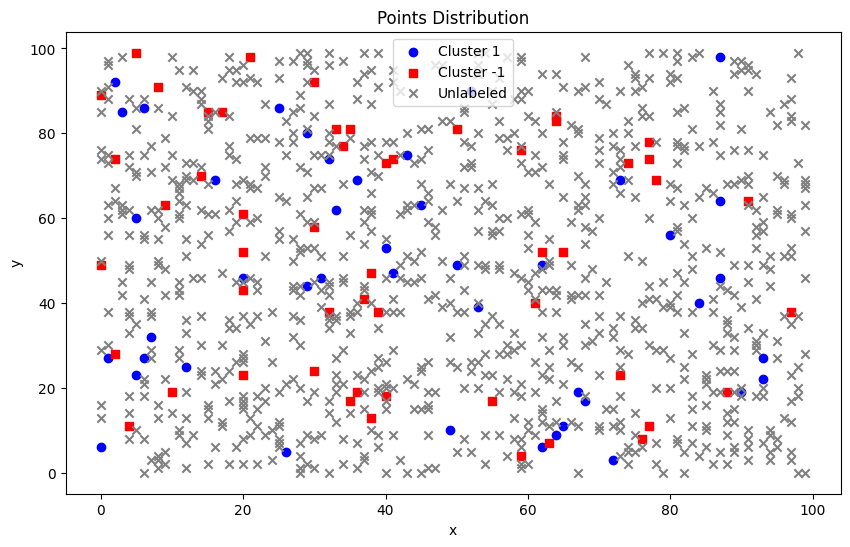

In [12]:
print("--- Phase 1.1: Artificial Points Generation ---")
# Create a random set of sparse points
points_df = generate_sparse_points(n=100, seed=seed)
plot_points(points_df)

# Loading the Real Dataset
The selected dataset if from Uber drivers in New York

We removed the label from the 90% of the data

--- Phase 1.2: Uber Points Generation ---


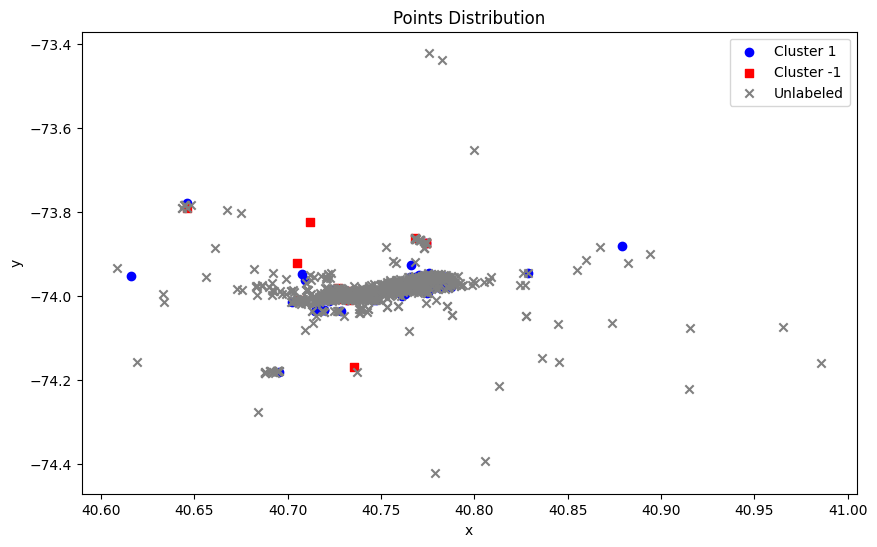

In [13]:
print("--- Phase 1.2: Uber Points Generation ---")
points_df_real = pd.read_csv("./uber_small.csv", header=None, names=['x', 'y', 'label'])
points_df_real['label'] = points_df_real['label'].map({'A': "1", 'B': "-1"})
np.random.seed(1)
mask = np.random.rand(len(points_df_real)) < 0.90
points_df_real.loc[mask, 'label'] = None
plot_points(points_df_real)

# Computation of GD on Artificial Data


--- Phase 2: Creation of the Optimization Problem (Artificial Data) ---

--- Phase 3: Optimal Solution Calculation (Artificial Data) ---

--- Phase 4: Initial guess for unlabelled points (Artificial Data) ---

--- Phase 5: Running GD (Artificial Data) ---

Running strategy: L
Strategy L completed -> Final function value: -40.284256

Running strategy: block_L
Strategy block_L completed -> Final function value: -40.284502

Running strategy: exact
Strategy exact completed -> Final function value: -39.747451

--- Phase 6: Plotting GD Results (Artificial Data) ---


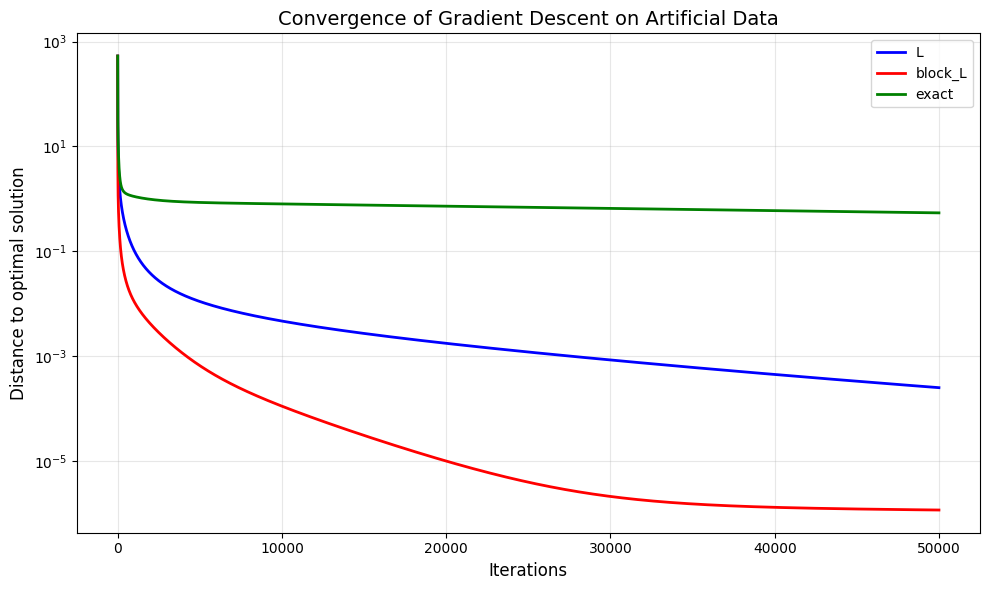

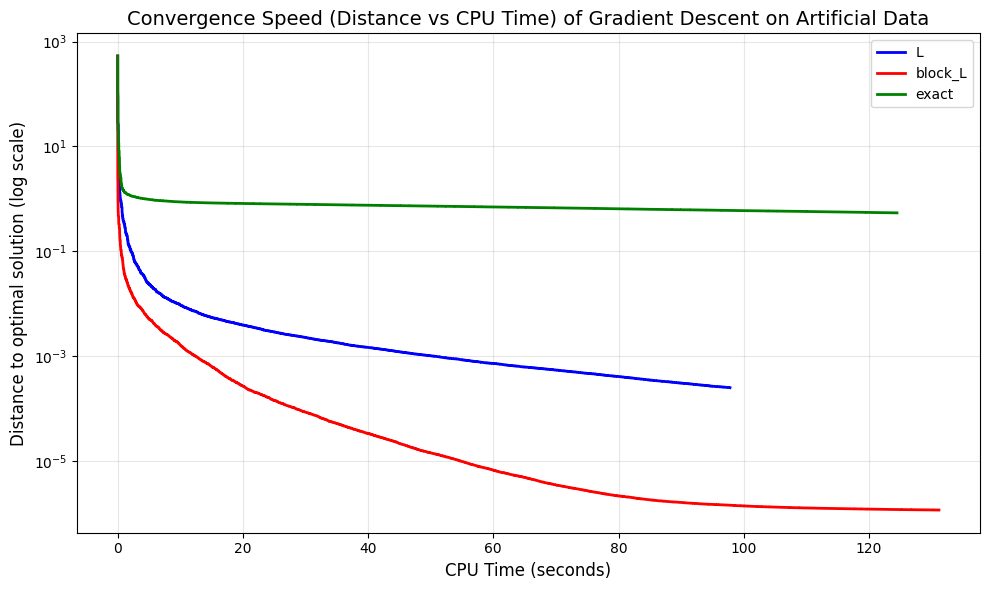


--- Execution of the GD on Synthetic Data Completed ---


In [14]:
print("\n--- Phase 2: Creation of the Optimization Problem (Artificial Data) ---")
# Creation of the optimization problem
fast_updates_f, safe_updates_f, Q, b = create_ssl_objective(
    points_df, sigma_w, sigma_bar_w, alpha_reg
)
# Number of unlabelled points
u = Q.shape[0]

print("\n--- Phase 3: Optimal Solution Calculation (Artificial Data) ---")
# Solve the linear system Qy = -b
y_optimal = np.linalg.solve(Q, -b)

# Calculate the optimal value of the function F(y)
f_optimal = 0.5 * y_optimal.T @ Q @ y_optimal + b.T @ y_optimal

print("\n--- Phase 4: Initial guess for unlabelled points (Artificial Data) ---")
np.random.seed(1)
y0 = np.random.randn(u)

print("\n--- Phase 5: Running GD (Artificial Data) ---")

# Strategies to compare
vec_stepsize_strats = ['L', 'block_L', 'exact']

# Dictionaries for the history
GD_art_dict_f_history = {}
GD_art_dict_y_opt = {}
GD_art_dict_time_history = {}

for step_strat_name in vec_stepsize_strats:
    print(f"\nRunning strategy: {step_strat_name}")

    # Create the specific function for stepsize using the calculated Q
    stepsize_func = stepsize_creator(step_strat_name, Q)

    # Run the GD solver
    y_opt_current, f_history_current, time_history_current = GD(
        safe_updates_f=safe_updates_f,
        x0=y0.copy(),
        num_iters=num_iters,
        tol=1e-6,
        step_size= stepsize_func,
        step_strat_name= step_strat_name
    )
    GD_art_dict_f_history[step_strat_name] = f_history_current
    GD_art_dict_y_opt[step_strat_name] = y_opt_current
    GD_art_dict_time_history[step_strat_name] = time_history_current
    print(f"Strategy {step_strat_name} completed -> Final function value: {f_history_current[-1]:.6f}")

print("\n--- Phase 6: Plotting GD Results (Artificial Data) ---")

# Plot distance to optimal solution vs. iterations for all GD strategies
plt.figure(figsize=(10, 6))

# Define colors for different strategies
colors = ['blue', 'red', 'green']
strategies = list(GD_art_dict_f_history.keys())

# Calculate distance to optimal value at each iteration for each strategy
for i, strategy in enumerate(strategies):
    f_history = GD_art_dict_f_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]
    iterations = range(len(f_history))
    plt.semilogy(iterations, optimality_gap, label=strategy, color=colors[i], linewidth=2)

# Plot with log scale on y-axis to better see the convergence
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Distance to optimal solution', fontsize=12)
plt.title('Convergence of Gradient Descent on Artificial Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

#----------------------------------------

# Plot distance vs CPU time for all the GD strategies
plt.figure(figsize=(10, 6))

for i, strategy in enumerate(strategies):
    f_history = GD_art_dict_f_history[strategy]
    time_history = GD_art_dict_time_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]

    plt.semilogy(time_history, optimality_gap, label=strategy, color=colors[i], linewidth=2)
    
plt.xlabel('CPU Time (seconds)', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Convergence Speed (Distance vs CPU Time) of Gradient Descent on Artificial Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("\n--- Execution of the GD on Synthetic Data Completed ---")

# Computation of GD on Real Data


--- Phase 2: Creation of the Optimization Problem (Real Data) ---

--- Phase 3: Optimal Solution Calculation (Real Data) ---

--- Phase 4: Initial guess for unlabelled points (Real Data) ---

--- Phase 5: Running GD (Real Data) ---

Running strategy: L
Strategy L completed -> Final function value: -32062.785754

Running strategy: block_L
Strategy block_L completed -> Final function value: -32062.785754

Running strategy: exact
Strategy exact completed -> Final function value: -32062.785754


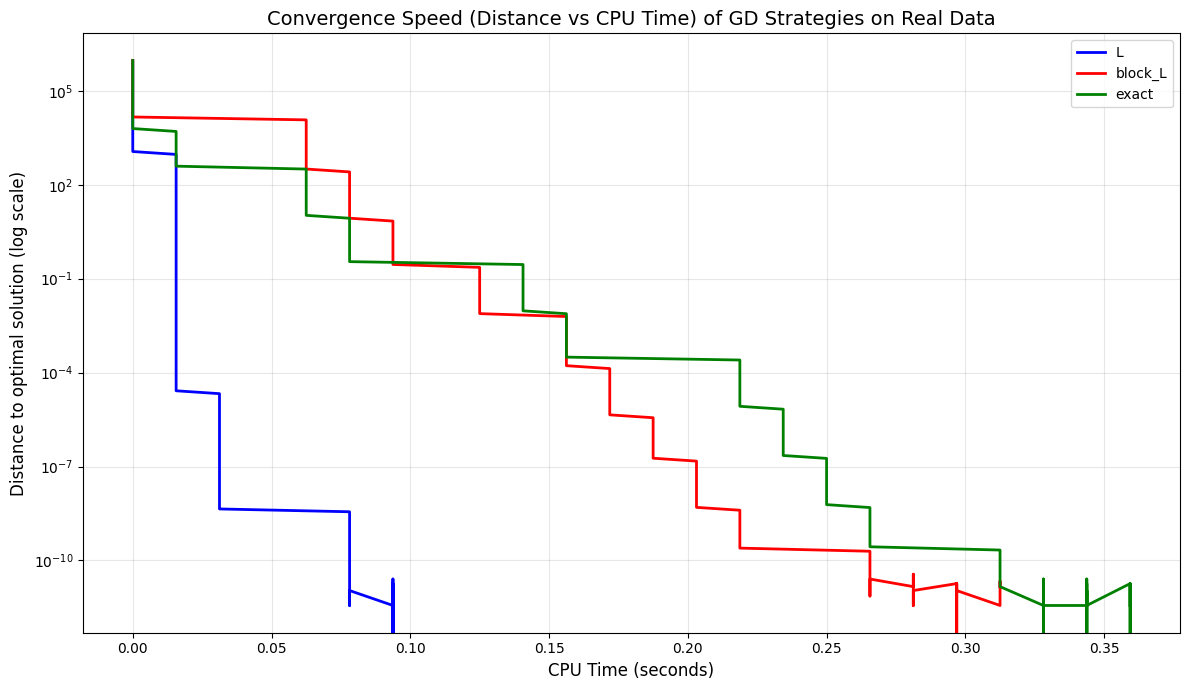


--- Execution of the GD on Real Data Completed ---


In [15]:
print("\n--- Phase 2: Creation of the Optimization Problem (Real Data) ---")
# Creation of the optimization problem
fast_updates_f, safe_updates_f, Q, b = create_ssl_objective(
    points_df_real, sigma_w, sigma_bar_w, alpha_reg
)
# Number of unlabelled points
u = Q.shape[0]

print("\n--- Phase 3: Optimal Solution Calculation (Real Data) ---")
# Solve the linear system Qy = -b
y_optimal = np.linalg.solve(Q, -b)

# Calculate the optimal value of the function F(y)
f_optimal = 0.5 * y_optimal.T @ Q @ y_optimal + b.T @ y_optimal

print("\n--- Phase 4: Initial guess for unlabelled points (Real Data) ---")
np.random.seed(1)
y0 = np.random.randn(u)

print("\n--- Phase 5: Running GD (Real Data) ---")
# Strategies to compare
vec_stepsize_strats = ['L', 'block_L', 'exact']

# Dictionaries for the history
GD_real_dict_f_history = {}
GD_real_dict_y_opt = {}
GD_real_dict_time_history = {}

for step_strat_name in vec_stepsize_strats:
    print(f"\nRunning strategy: {step_strat_name}")

    # Create the specific function for stepsize using the calculated Q
    stepsize_func = stepsize_creator(step_strat_name, Q)

    # Run the GD solver
    y_opt_current, f_history_current, time_history_current = GD(
        safe_updates_f = safe_updates_f,
        x0 = y0.copy(),
        num_iters = num_iters,
        tol = 1e-6,
        step_size = stepsize_func,
        step_strat_name= step_strat_name
    )
    GD_real_dict_f_history[step_strat_name] = f_history_current
    GD_real_dict_y_opt[step_strat_name] = y_opt_current
    GD_real_dict_time_history[step_strat_name] = time_history_current
    print(f"Strategy {step_strat_name} completed -> Final function value: {f_history_current[-1]:.6f}")

#----------------------------------------

# Plot distance to optimal vs. CPU time for all GD strategies
plt.figure(figsize=(12, 7))

for i, strategy in enumerate(strategies):
    f_history = GD_real_dict_f_history[strategy]
    time_history = GD_real_dict_time_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]

    plt.semilogy(time_history, optimality_gap, label=strategy, color=colors[i], linewidth=2)

plt.xlabel('CPU Time (seconds)', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Convergence Speed (Distance vs CPU Time) of GD Strategies on Real Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\n--- Execution of the GD on Real Data Completed ---")

# Computation of BCGD_GS on Artificial Data


--- Phase 2 : Creation of the Optimization Problem (Artificial Data) ---

--- Phase 3: Optimal Solution Calculation (Artificial Data) ---

--- Phase 4: Initial guess for unlabelled points (Artificial Data) ---

--- Phase 5: Running BCGD-GS with Different Strategies (Artificial Data) ---

Running strategy: L+abs
Strategy L+abs completed -> Final function value: -39.179797

Running strategy: block_L+abs_L
Strategy block_L+abs_L completed -> Final function value: -40.210640

Running strategy: exact+max_improvement
Strategy exact+max_improvement completed -> Final function value: -40.251586

--- Phase 6: Plotting BCGS-GS Results (Artificial Data) ---


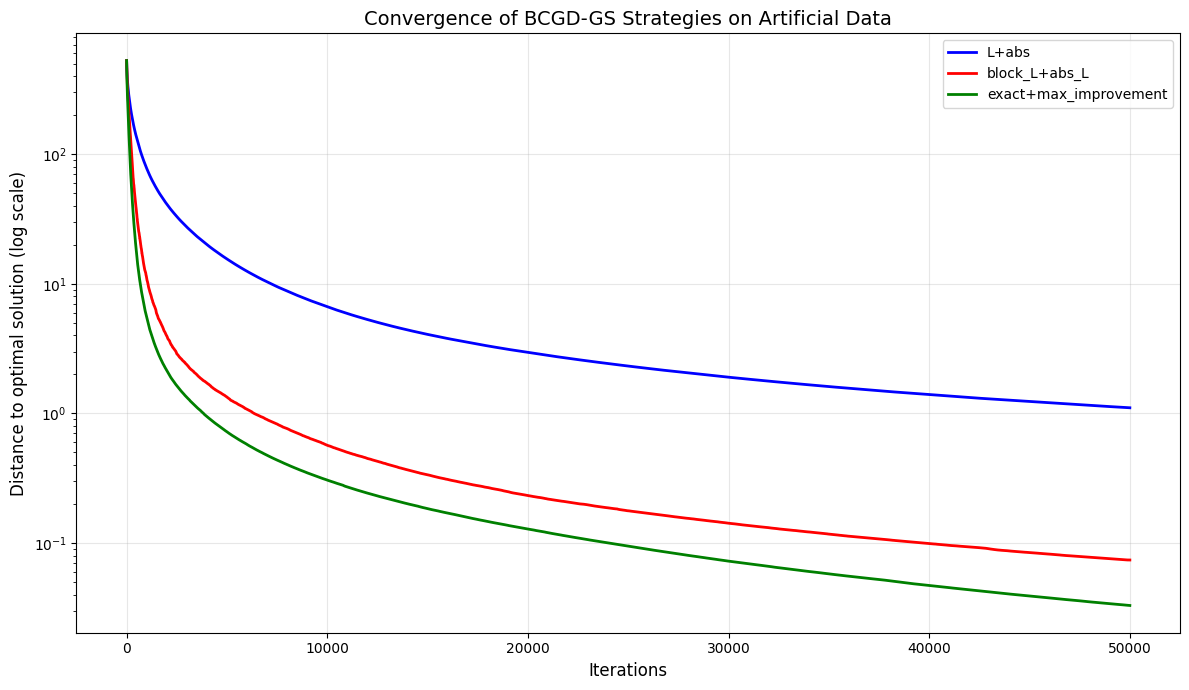

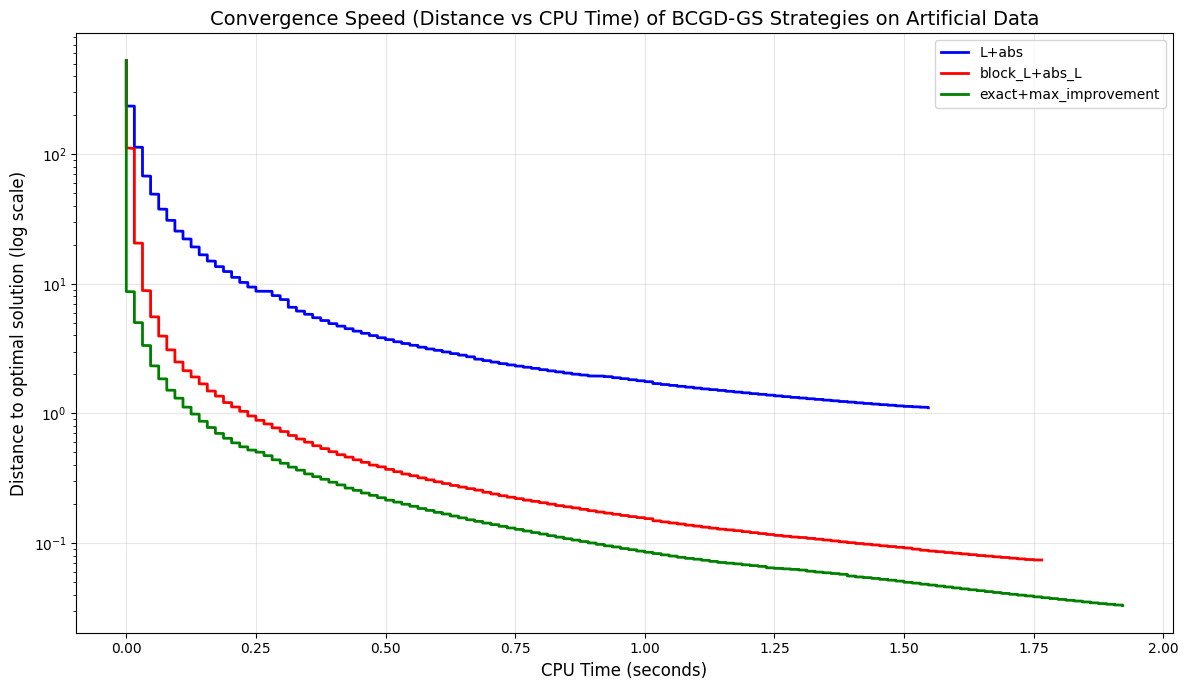


--- Execution of the BCGD with GS on Synthetic Data Completed ---


In [16]:
print("\n--- Phase 2 : Creation of the Optimization Problem (Artificial Data) ---")
# Creation of the optimization problem
fast_updates_f, safe_updates_f, Q, b = create_ssl_objective(
    points_df, sigma_w, sigma_bar_w, alpha_reg
)
# Number of unlabelled points
u = Q.shape[0]

print("\n--- Phase 3: Optimal Solution Calculation (Artificial Data) ---")
# Solve the linear system Qy = -b
y_optimal = np.linalg.solve(Q, -b)

# Calculate the optimal value of the function F(y)
f_optimal = 0.5 * y_optimal.T @ Q @ y_optimal + b.T @ y_optimal

print("\n--- Phase 4: Initial guess for unlabelled points (Artificial Data) ---")
np.random.seed(1)
y0 = np.random.randn(u)

print("\n--- Phase 5: Running BCGD-GS with Different Strategies (Artificial Data) ---")
# Strategies to compare
vec_stepsize_strats = ['L', 'block_L', 'exact']
vec_priority_strats = ['abs', 'abs_L', 'max_improvement']

# Dictionaries for the history - for artificial data
BCGD_art_dict_f_history = {}
BCGD_art_dict_y_opt = {}
BCGD_art_dict_time_history = {}

for step_strat_name, prio_strat_name in zip(vec_stepsize_strats, vec_priority_strats):
    strategy = step_strat_name + '+' + prio_strat_name
    print(f"\nRunning strategy: {strategy}")

    # Create the specific functions for stepsize and priority using the calculated Q
    stepsize_func = stepsize_creator(step_strat_name, Q)
    priority_func = max_priority_generator(prio_strat_name, Q)

    # Run the BCGD-GS solver
    y_opt_current, f_history_current, time_history_current = BCGD_GS(
        fast_updates_f=fast_updates_f,
        safe_updates_f=safe_updates_f,
        x0=y0.copy(),
        num_iters=num_iters,
        tol=1e-6,
        f_priorities=priority_func,
        stepsize_strat=stepsize_func
    )
    BCGD_art_dict_f_history[strategy] = f_history_current
    BCGD_art_dict_y_opt[strategy] = y_opt_current
    BCGD_art_dict_time_history[strategy] = time_history_current
    print(f"Strategy {strategy} completed -> Final function value: {f_history_current[-1]:.6f}")

print("\n--- Phase 6: Plotting BCGS-GS Results (Artificial Data) ---")

# Plot distance to optimal solution vs. iterations for all BCGD-GS strategies
plt.figure(figsize=(12, 7))

# Define colors for different strategies
colors = ['blue', 'red', 'green']
strategies = list(BCGD_art_dict_f_history.keys())

# Plot with log scale for each strategy
for i, strategy in enumerate(strategies):
    f_history = BCGD_art_dict_f_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]
    iterations = range(len(f_history))
    plt.semilogy(iterations, optimality_gap, label=strategy, color=colors[i], linewidth=2)

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Convergence of BCGD-GS Strategies on Artificial Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

#----------------------------------------

# Plot distance to optimal vs. CPU time for all BCGD-GS strategies
plt.figure(figsize=(12, 7))

for i, strategy in enumerate(strategies):
    f_history = BCGD_art_dict_f_history[strategy]
    time_history = BCGD_art_dict_time_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]

    # Plot distance vs CPU time (using semilogy)
    plt.semilogy(time_history, optimality_gap, label=strategy, color=colors[i], linewidth=2)

plt.xlabel('CPU Time (seconds)', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Convergence Speed (Distance vs CPU Time) of BCGD-GS Strategies on Artificial Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("\n--- Execution of the BCGD with GS on Synthetic Data Completed ---")

# Computation of BCGD_GS on Real Data


--- Phase 2: Creation of the Optimization Problem (Real Data) ---

--- Phase 3: Optimal Solution Calculation (Real Data) ---

--- Phase 4: Initial guess for unlabelled points (Real Data) ---

--- Phase 5: Running BCGD-GS with Different Strategies (Real Data) ---

Running strategy: L+abs
Strategy L+abs completed -> Final function value: -32062.785752

Running strategy: block_L+abs_L
Strategy block_L+abs_L completed -> Final function value: -32062.785752

Running strategy: exact+max_improvement
Strategy exact+max_improvement completed -> Final function value: -32062.784666

--- Phase 6: Plotting BCGS-GS Results (Real Data) ---


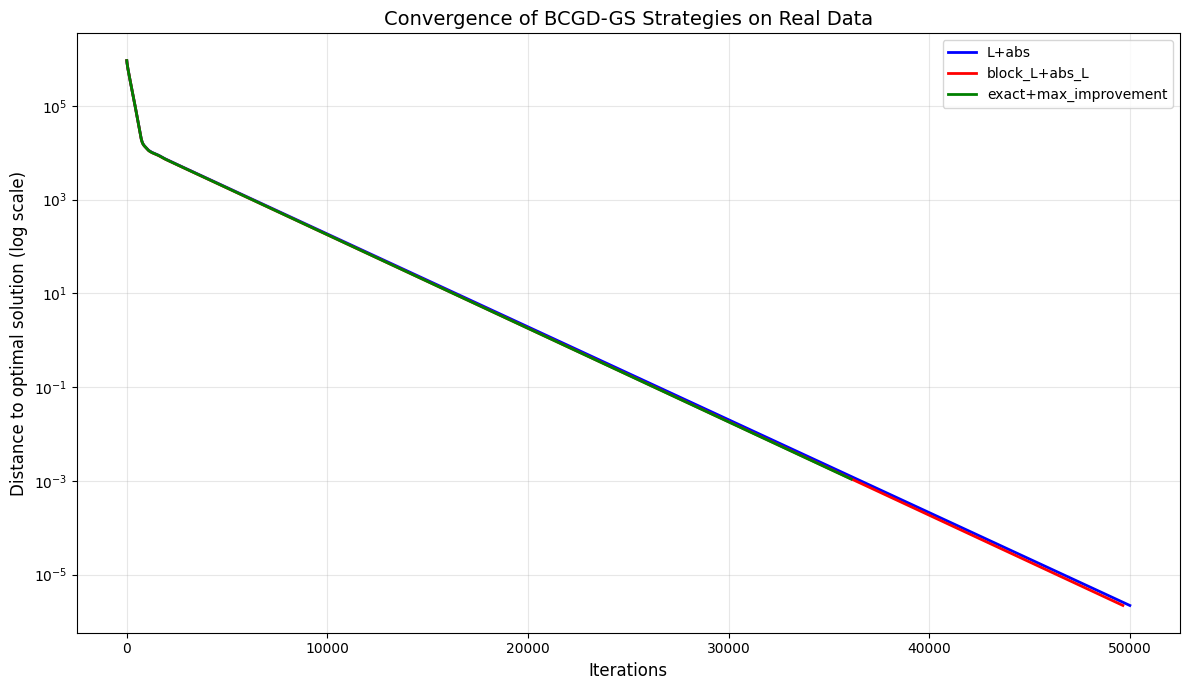

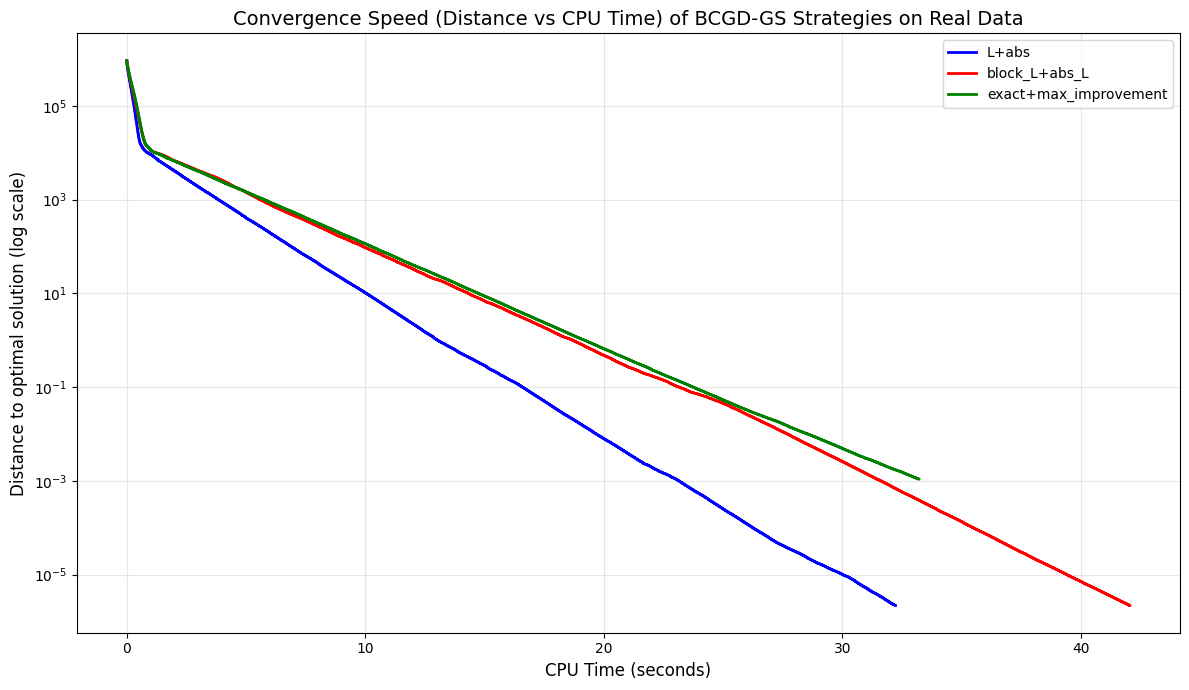


--- Execution of the BCGD with GS on Real Data Completed ---


In [17]:
print("\n--- Phase 2: Creation of the Optimization Problem (Real Data) ---")
# Creation of the optimization problem
fast_updates_f, safe_updates_f, Q, b = create_ssl_objective(
    points_df_real, sigma_w, sigma_bar_w, alpha_reg
)
# Number of unlabelled points
u = Q.shape[0]

print("\n--- Phase 3: Optimal Solution Calculation (Real Data) ---")
# Solve the linear system Qy = -b
y_optimal = np.linalg.solve(Q, -b)

# Calculate the optimal value of the function F(y)
f_optimal = 0.5 * y_optimal.T @ Q @ y_optimal + b.T @ y_optimal

print("\n--- Phase 4: Initial guess for unlabelled points (Real Data) ---")
np.random.seed(1)
y0_real = np.random.randn(u)

print("\n--- Phase 5: Running BCGD-GS with Different Strategies (Real Data) ---")
# Strategies to compare
vec_stepsize_strats = ['L', 'block_L', 'exact']
vec_priority_strats = ['abs', 'abs_L', 'max_improvement']

# Dictionaries for the history - for real data
BCGD_real_dict_f_history = {}
BCGD_real_dict_y_opt = {}
BCGD_real_dict_time_history = {}

for step_strat_name, prio_strat_name in zip(vec_stepsize_strats, vec_priority_strats):
    strategy = step_strat_name + '+' + prio_strat_name
    print(f"\nRunning strategy: {strategy}")

    # Create the specific functions for stepsize and priority using the calculated Q
    stepsize_func = stepsize_creator(step_strat_name, Q)
    priority_func = max_priority_generator(prio_strat_name, Q)

    # Run the BCGD-GS solver
    y_opt_current, f_history_current, time_history_current = BCGD_GS(
        fast_updates_f=fast_updates_f,
        safe_updates_f=safe_updates_f,
        x0=y0_real.copy(),
        num_iters=num_iters,
        tol=1e-6,
        f_priorities=priority_func,
        stepsize_strat=stepsize_func
    )
    BCGD_real_dict_f_history[strategy] = f_history_current
    BCGD_real_dict_y_opt[strategy] = y_opt_current
    BCGD_real_dict_time_history[strategy] = time_history_current
    print(f"Strategy {strategy} completed -> Final function value: {f_history_current[-1]:.6f}")

print("\n--- Phase 6: Plotting BCGS-GS Results (Real Data) ---")

# Plot distance to optimal solution vs. iterations for all BCGD-GS strategies
plt.figure(figsize=(12, 7))

# Define colors for different strategies
colors = ['blue', 'red', 'green']
strategies = list(BCGD_real_dict_f_history.keys())

# Plot with log scale for each strategy
for i, strategy in enumerate(strategies):
    f_history = BCGD_real_dict_f_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]
    iterations = range(len(f_history))
    plt.semilogy(iterations, optimality_gap, label=strategy, color=colors[i], linewidth=2)

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Convergence of BCGD-GS Strategies on Real Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

#----------------------------------------

# Plot distance to optimal vs. CPU time for all BCGD-GS strategies
plt.figure(figsize=(12, 7))

for i, strategy in enumerate(strategies):
    f_history = BCGD_real_dict_f_history[strategy]
    time_history = BCGD_real_dict_time_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]

    # Plot distance vs CPU time (using semilogy)
    plt.semilogy(time_history, optimality_gap, label=strategy, color=colors[i], linewidth=2)

plt.xlabel('CPU Time (seconds)', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Convergence Speed (Distance vs CPU Time) of BCGD-GS Strategies on Real Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("\n--- Execution of the BCGD with GS on Real Data Completed ---")

# Computation of CM on Artificial Data


--- Phase 2: Creation of the Optimization Problem (Artificial Data) ---

--- Phase 3: Optimal Solution Calculation (Artificial Data) ---

--- Phase 4: Initial guess for unlabelled points (Artificial Data) ---

--- Phase 5: Running CD Algorithm (Artificial Data) ---

Running CD with L stepsize strategy
Strategy L completed -> Final function value: -36.874099

Running CD with block_L stepsize strategy
Strategy block_L completed -> Final function value: -39.914539

Running CD with exact stepsize strategy
Strategy exact completed -> Final function value: -40.003099

--- Phase 6: Plotting CD Results (Artificial Data) ---


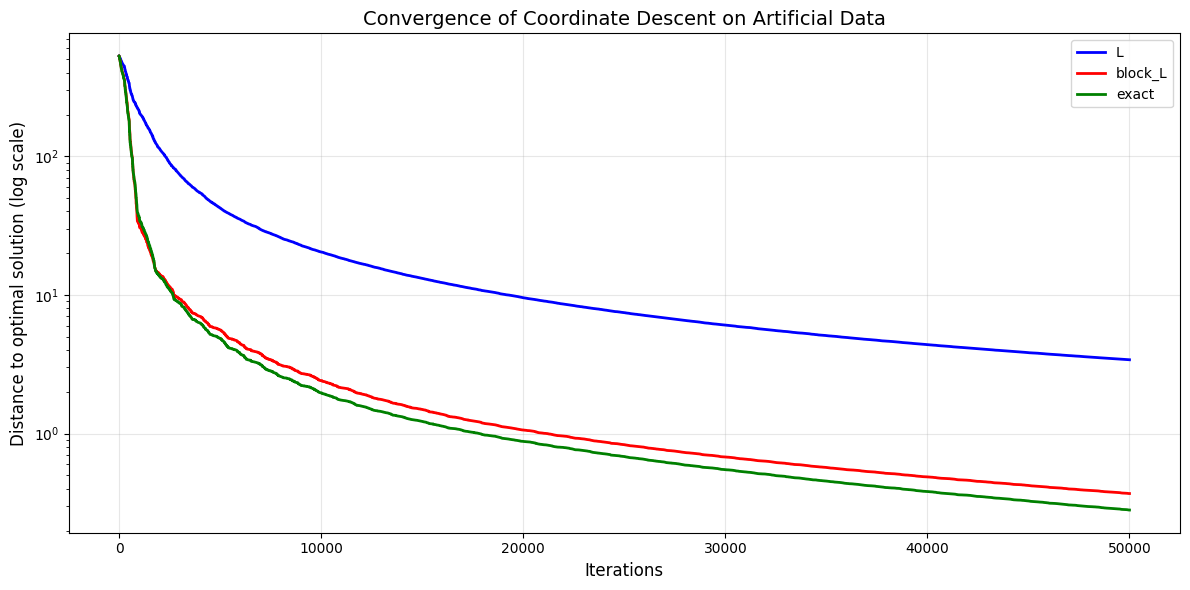

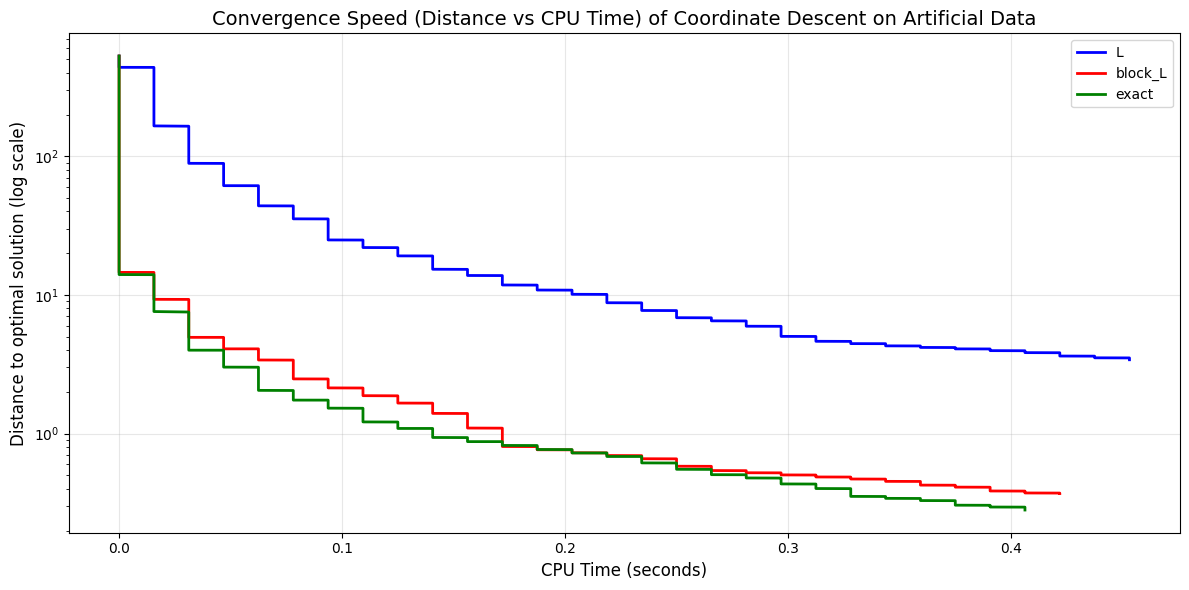


--- Execution of the CD on Synthetic Data Completed ---


In [18]:
print("\n--- Phase 2: Creation of the Optimization Problem (Artificial Data) ---")
# Creation of the optimization problem
fast_updates_f, safe_updates_f, Q, b = create_ssl_objective(
    points_df, sigma_w, sigma_bar_w, alpha_reg
)
# Number of unlabelled points
u = Q.shape[0]

print("\n--- Phase 3: Optimal Solution Calculation (Artificial Data) ---")
# Solve the linear system Qy = -b
y_optimal = np.linalg.solve(Q, -b)

# Calculate the optimal value of the function F(y)
f_optimal = 0.5 * y_optimal.T @ Q @ y_optimal + b.T @ y_optimal

print("\n--- Phase 4: Initial guess for unlabelled points (Artificial Data) ---")
np.random.seed(1)
y0 = np.random.randn(u)

print("\n--- Phase 5: Running CD Algorithm (Artificial Data) ---")

# Stepsize strategies
vec_stepsize_strats = ['L', 'block_L', 'exact']

# Dictionary for the history
CD_art_dict_f_history = {}
CD_art_dict_y_opt = {}
CD_art_dict_time_history = {}

for stepsize_strategy in vec_stepsize_strats:
# Run the CD solver once
    print(f"\nRunning CD with {stepsize_strategy} stepsize strategy")

    # Create the step size function
    step_size_func = stepsize_creator(stepsize_strategy, Q)

    y_opt_current, f_history_current, time_history_current = CD(
        fast_updates_f=fast_updates_f,
        safe_updates_f=safe_updates_f,
        x0=y0.copy(),
        num_iters=num_iters,
        tol=1e-6,
        seed = seed,
        step_size=step_size_func
    )
    CD_art_dict_f_history[stepsize_strategy] = f_history_current
    CD_art_dict_y_opt[stepsize_strategy] = y_opt_current
    CD_art_dict_time_history[stepsize_strategy] = time_history_current
    print(f"Strategy {stepsize_strategy} completed -> Final function value: {f_history_current[-1]:.6f}")

print("\n--- Phase 6: Plotting CD Results (Artificial Data) ---")

# Plot distance to optimal solution vs. iterations for CD
plt.figure(figsize=(12, 6))

# Define colors for different strategies
colors = ['blue', 'red', 'green']
strategies = list(CD_art_dict_f_history.keys())

# Plot with log scale for each strategy
for i, strategy in enumerate(strategies):
    f_history = CD_art_dict_f_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]
    iterations = range(len(f_history))
    plt.semilogy(iterations, optimality_gap, label=strategy, color=colors[i], linewidth=2)

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Convergence of Coordinate Descent on Artificial Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

#----------------------------------------

# Plot distance to optimal vs. CPU time for CD
plt.figure(figsize=(12, 6))

for i, strategy in enumerate(strategies):
    f_history = CD_art_dict_f_history[strategy]
    time_history = CD_art_dict_time_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]

    # Plot distance vs CPU time
    plt.semilogy(time_history, optimality_gap, label=strategy, color=colors[i], linewidth=2)

plt.xlabel('CPU Time (seconds)', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Convergence Speed (Distance vs CPU Time) of Coordinate Descent on Artificial Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("\n--- Execution of the CD on Synthetic Data Completed ---")

# Computation of CM on Real Data


--- Phase 2: Creation of the Optimization Problem (Real Data) ---

--- Phase 3: Optimal Solution Calculation (Real Data) ---

--- Phase 4: Initial guess for unlabelled points (Real Data) ---

--- Phase 5: Running CD Algorithm (Real Data) ---

Running strategy: L
Strategy L completed -> Final function value: -32062.785656

Running strategy: block_L
Strategy block_L completed -> Final function value: -32062.785666

Running strategy: exact
Strategy exact completed -> Final function value: -32062.785667

--- Phase 6: Plotting CD Results (Real Data) ---


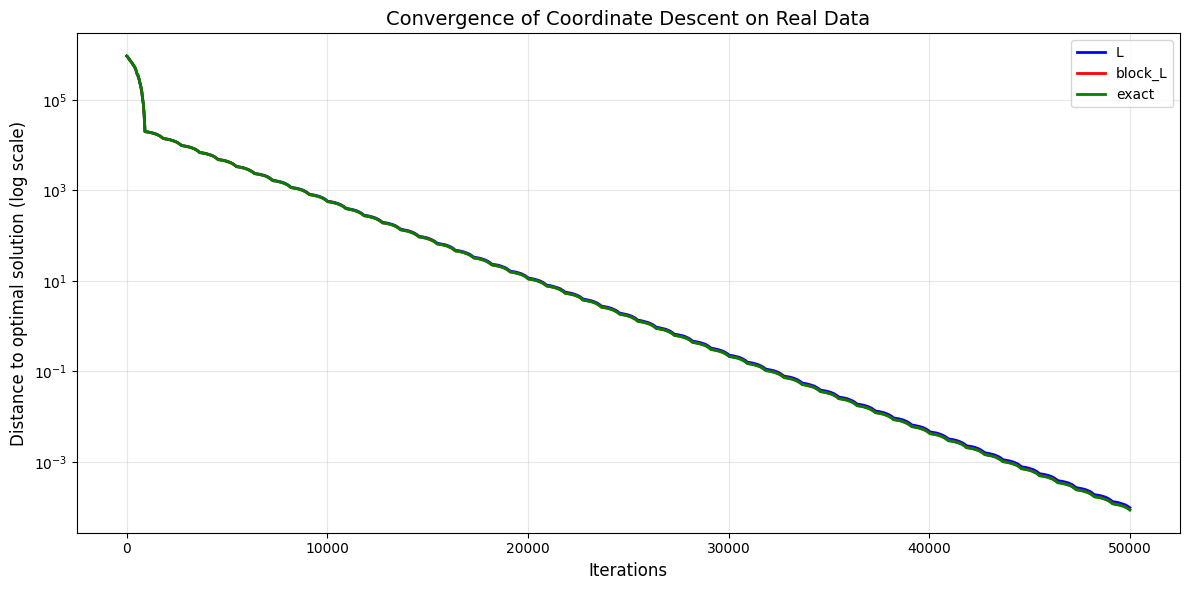

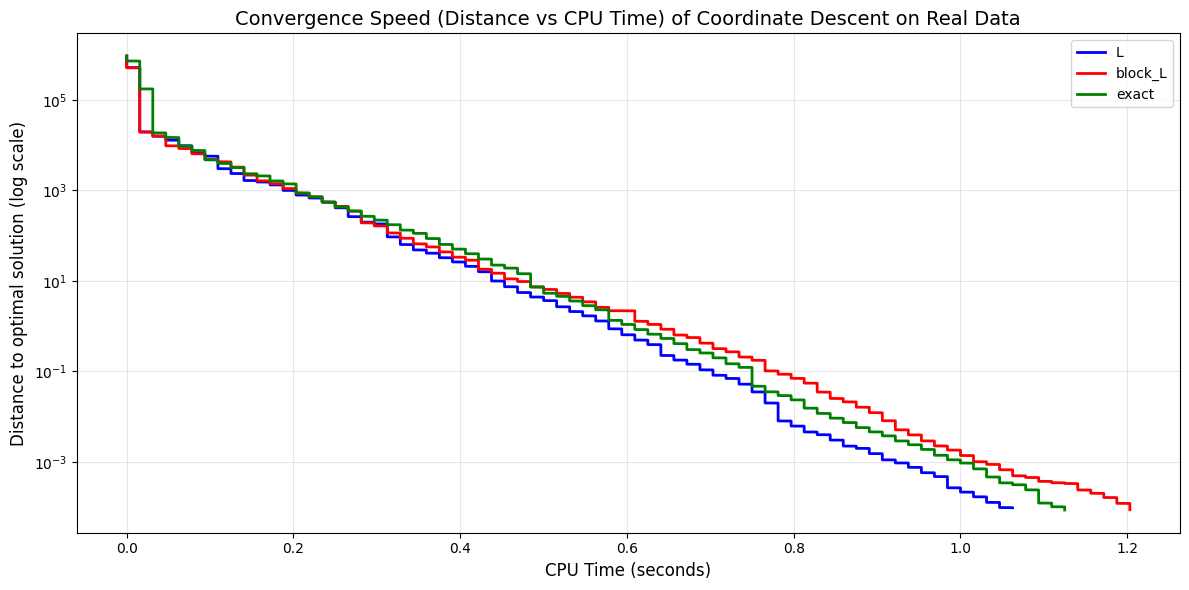


--- Execution of the CD on Real Data Completed ---


In [19]:
print("\n--- Phase 2: Creation of the Optimization Problem (Real Data) ---")
# Creation of the optimization problem
fast_updates_f, safe_updates_f, Q, b = create_ssl_objective(
    points_df_real, sigma_w, sigma_bar_w, alpha_reg
)
# Number of unlabelled points
u = Q.shape[0]

print("\n--- Phase 3: Optimal Solution Calculation (Real Data) ---")
# Solve the linear system Qy = -b
y_optimal = np.linalg.solve(Q, -b)

# Calculate the optimal value of the function F(y)
f_optimal = 0.5 * y_optimal.T @ Q @ y_optimal + b.T @ y_optimal

print("\n--- Phase 4: Initial guess for unlabelled points (Real Data) ---")
np.random.seed(1)
y0 = np.random.randn(u)

print("\n--- Phase 5: Running CD Algorithm (Real Data) ---")
# Dictionary for the history
CD_real_dict_f_history = {}
CD_real_dict_y_opt = {}
CD_real_dict_time_history = {}

# Strategies to compare
vec_stepsize_strats = ['L', 'block_L', 'exact']

# Run the CD solver

for stepsize_strategy in vec_stepsize_strats:
    print(f"\nRunning strategy: {stepsize_strategy}")

    # Create the specific function for stepsize using the calculated Q
    stepsize_func = stepsize_creator(stepsize_strategy, Q)

    y_opt_current, f_history_current, time_history_current = CD(
        fast_updates_f=fast_updates_f,
        safe_updates_f=safe_updates_f,
        x0=y0_real.copy(),
        num_iters=num_iters,
        tol=1e-6,
        seed=seed,
        step_size=stepsize_func
    )
    CD_real_dict_f_history[stepsize_strategy] = f_history_current
    CD_real_dict_y_opt[stepsize_strategy] = y_opt_current
    CD_real_dict_time_history[stepsize_strategy] = time_history_current
    print(f"Strategy {stepsize_strategy} completed -> Final function value: {f_history_current[-1]:.6f}")

print("\n--- Phase 6: Plotting CD Results (Real Data) ---")

# Plot distance to optimal solution vs. iterations for CD
plt.figure(figsize=(12, 6))

# Define colors for different strategies
colors = ['blue', 'red', 'green']
strategies = list(CD_real_dict_f_history.keys())

# Plot with log scale for each strategy
for i, strategy in enumerate(strategies):
    f_history = CD_real_dict_f_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]
    iterations = range(len(f_history))
    plt.semilogy(iterations, optimality_gap, label=strategy, color=colors[i], linewidth=2)

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Convergence of Coordinate Descent on Real Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

#----------------------------------------

# Plot distance to optimal vs. CPU time for CD
plt.figure(figsize=(12, 6))

for i, strategy in enumerate(strategies):
    f_history = CD_real_dict_f_history[strategy]
    time_history = CD_real_dict_time_history[strategy]
    optimality_gap = [abs(f - f_optimal) for f in f_history]

    # Plot distance vs CPU time
    plt.semilogy(time_history, optimality_gap, label=strategy, color=colors[i], linewidth=2)

plt.xlabel('CPU Time (seconds)', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Convergence Speed (Distance vs CPU Time) of Coordinate Descent on Real Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("\n--- Execution of the CD on Real Data Completed ---")

# Comparisons Between Strategies
Now we compare the Gradient Descent, the Coordinate minimization and the best combination of strategies for the Block Coordinate Gradient Descent with Gauss-Southwell Rule into the two plots: Distance to optimal vs Iteration and Accuracy vs CPU-Timme


--- Phase 7: Comparison Plots (Artificial Data) ---



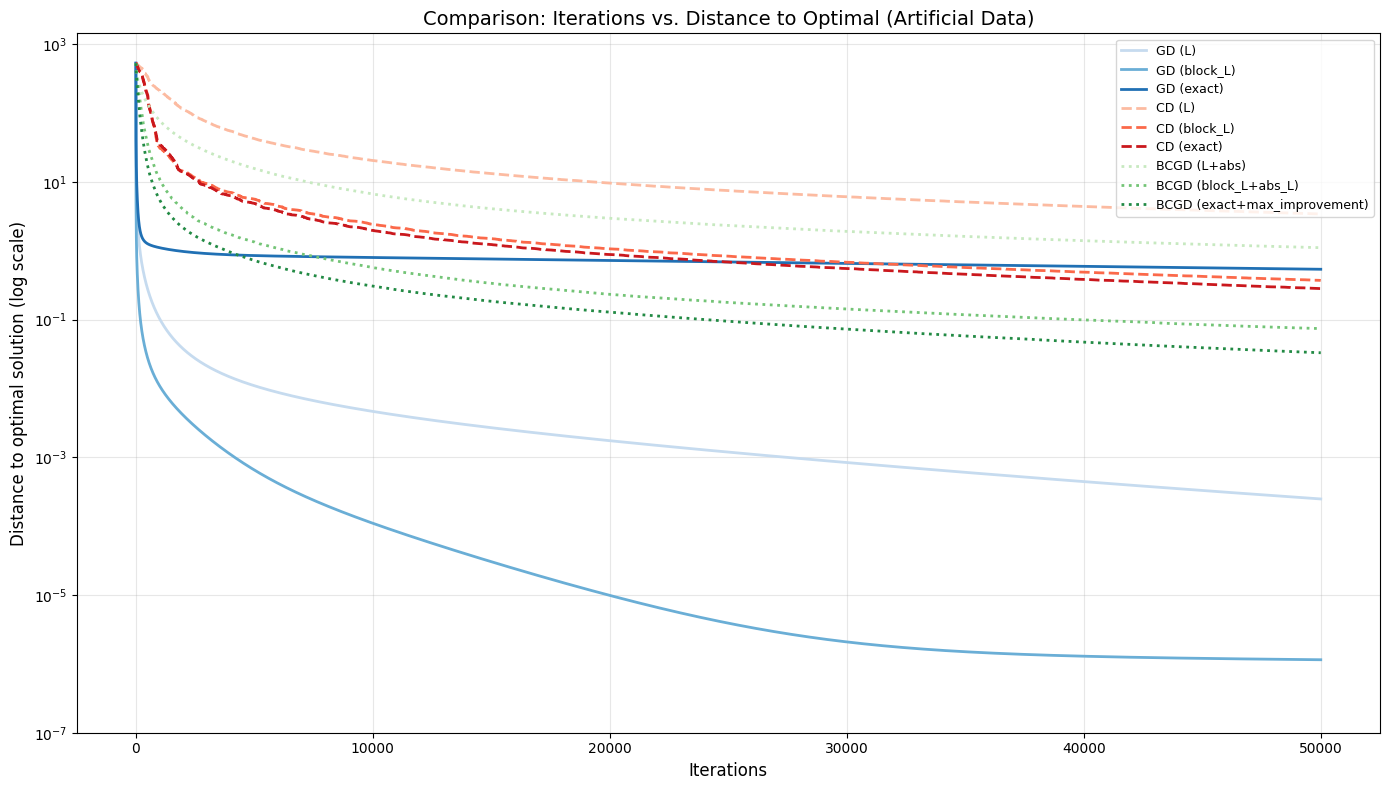

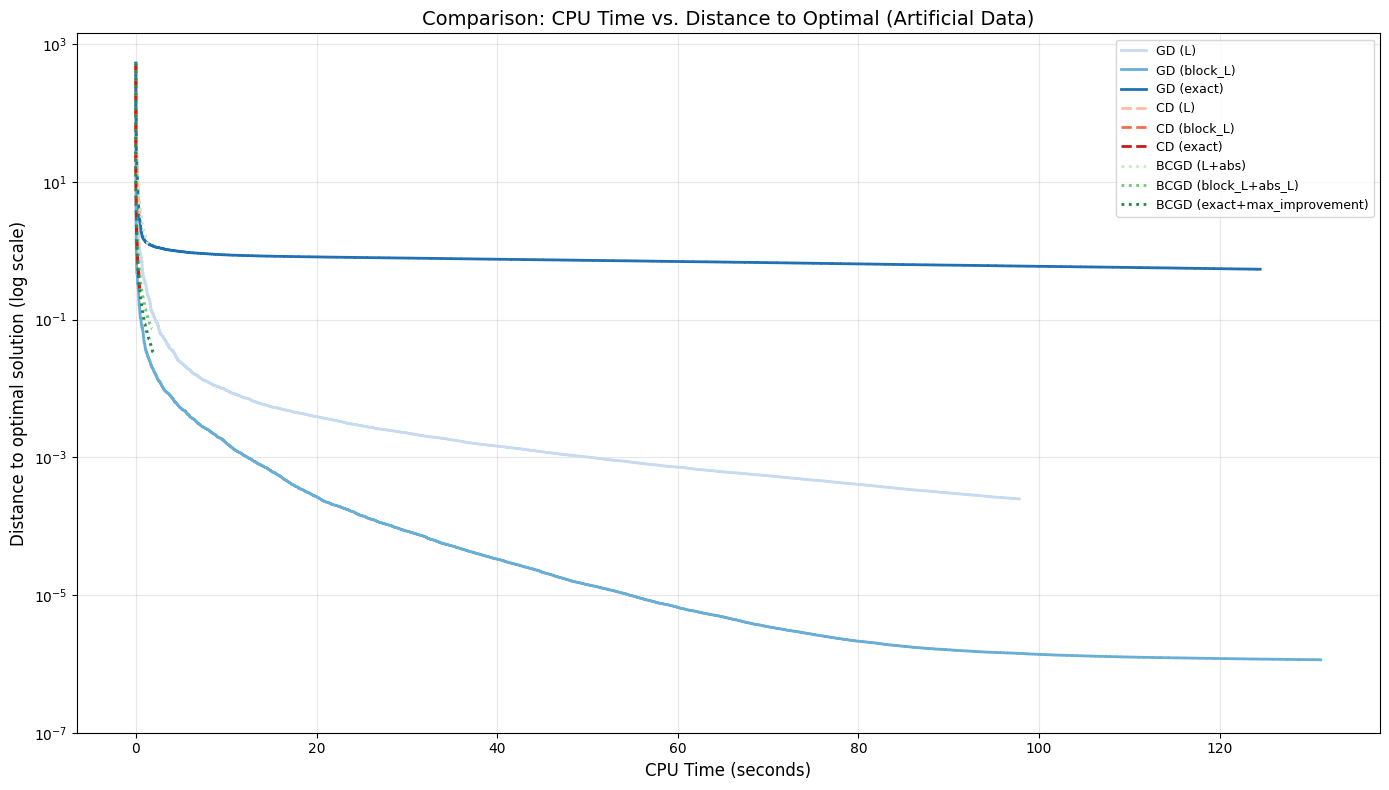


--- Comparison Plots for Artificial Data Completed ---


--- Phase 8: Comparison Plots (Real Data) ---



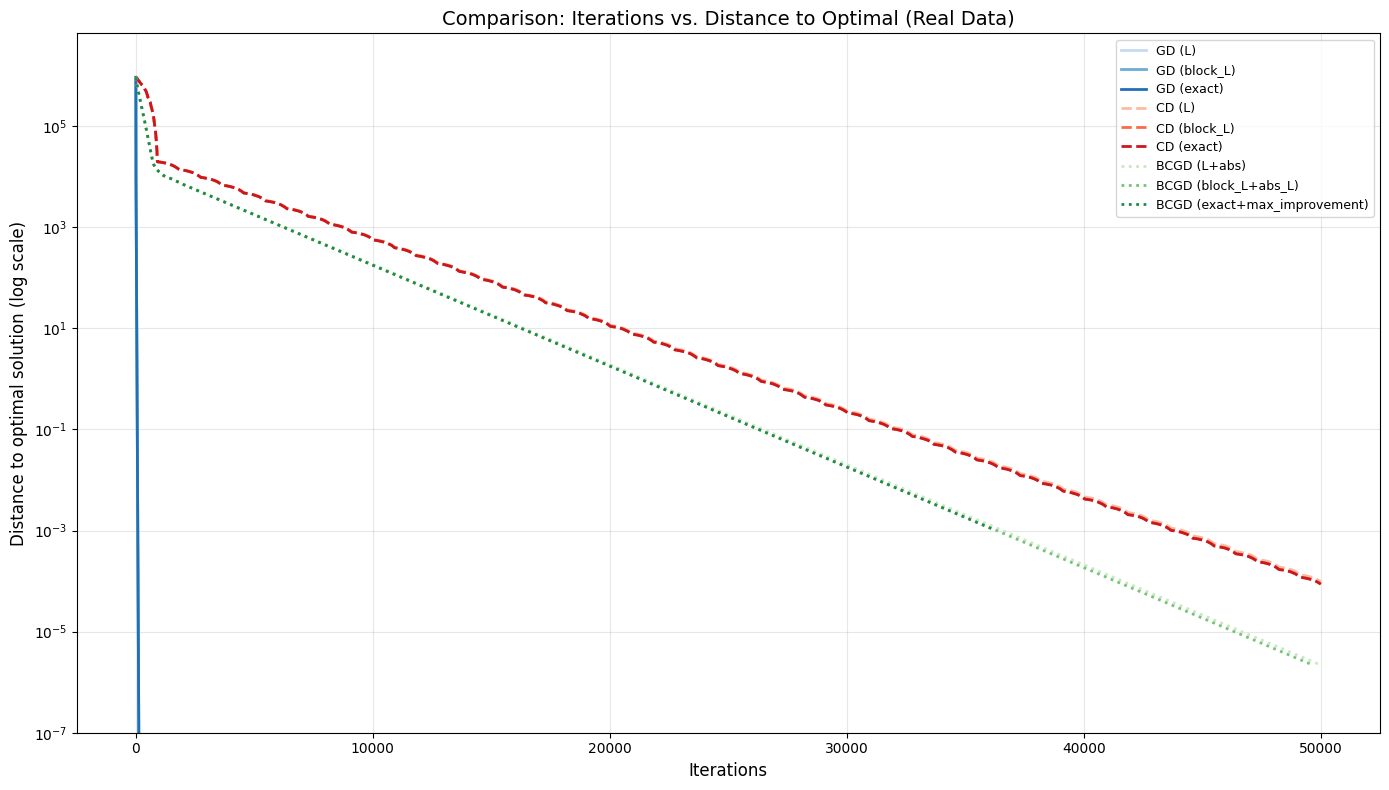

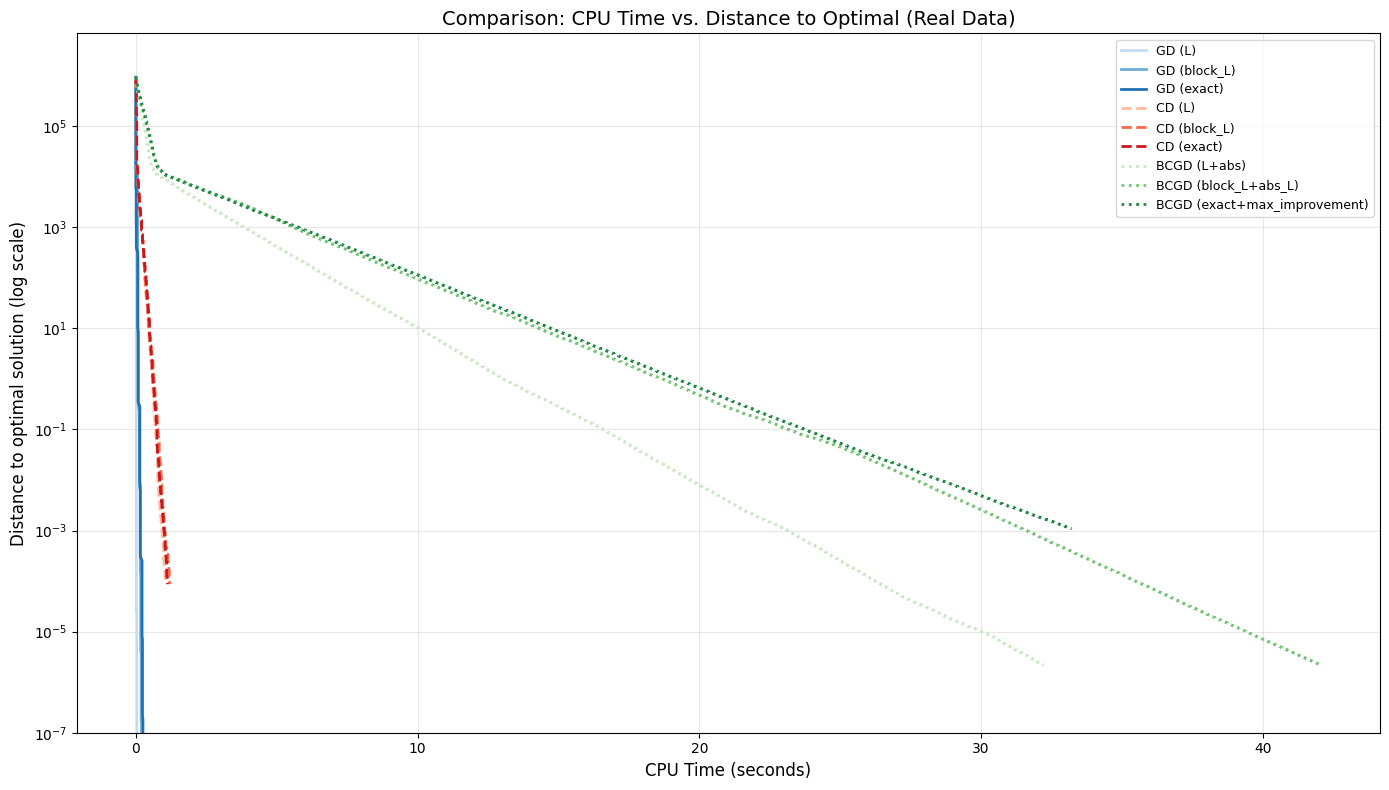


--- Comparison Plots for Real Data Completed ---



In [20]:
print("\n--- Phase 7: Comparison Plots (Artificial Data) ---\n")

# Recompute optimal solution for clarity
fast_updates_f_art, safe_updates_f_art, Q_art, b_art = create_ssl_objective(
    points_df, sigma_w, sigma_bar_w, alpha_reg
)
y_optimal_art = np.linalg.solve(Q_art, -b_art)
f_optimal_art = 0.5 * y_optimal_art.T @ Q_art @ y_optimal_art + b_art.T @ y_optimal_art
f_optimal = f_optimal_art


# --- Iterations vs Distance to Optimal (Artificial Data) ---
plt.figure(figsize=(14, 8))

# Define colors and linestyles
cmap_gd = plt.get_cmap('Blues')
cmap_bcgd = plt.get_cmap('Greens')
cmap_cd = plt.get_cmap('Reds')

gd_strategies = list(GD_art_dict_f_history.keys())
bcgd_strategies = list(BCGD_art_dict_f_history.keys())
cd_strategies = list(CD_art_dict_f_history.keys())

num_gd = len(gd_strategies)
num_bcgd = len(bcgd_strategies)
num_cd = len(cd_strategies)

colors = {}
linestyles = {}

# Assign colors/styles for GD strategies
for i, strategy in enumerate(gd_strategies):
    colors[f'GD_{strategy}'] = cmap_gd((i + 1) / (num_gd + 1))
    linestyles[f'GD_{strategy}'] = '-'

# Assign colors/styles for BCGD strategies
for i, strategy in enumerate(bcgd_strategies):
    colors[f'BCGD_{strategy}'] = cmap_bcgd((i + 1) / (num_bcgd + 1))
    linestyles[f'BCGD_{strategy}'] = ':'

# Assign colors/styles for CD strategies
for i, strategy in enumerate(cd_strategies):
    colors[f'CD_{strategy}'] = cmap_cd((i + 1) / (num_cd + 1))
    linestyles[f'CD_{strategy}'] = '--'


# Plot All GD Variants
for strategy in gd_strategies:
    f_history_gd = GD_art_dict_f_history[strategy]
    optimality_gap_gd = [abs(f - f_optimal) for f in f_history_gd]
    iterations_gd = range(len(f_history_gd))
    plt.semilogy(iterations_gd, optimality_gap_gd, label=f'GD ({strategy})',
                 color=colors[f'GD_{strategy}'], linestyle=linestyles[f'GD_{strategy}'], linewidth=2)

# Plot All CD Variants
for strategy in cd_strategies:
    f_history_cd = CD_art_dict_f_history[strategy]
    optimality_gap_cd = [abs(f - f_optimal) for f in f_history_cd]
    iterations_cd = range(len(f_history_cd))
    plt.semilogy(iterations_cd, optimality_gap_cd, label=f'CD ({strategy})',
                 color=colors[f'CD_{strategy}'], linestyle=linestyles[f'CD_{strategy}'], linewidth=2)

# Plot All BCGD Variants
for strategy in bcgd_strategies:
    f_history_bcgd = BCGD_art_dict_f_history[strategy]
    optimality_gap_bcgd = [abs(f - f_optimal) for f in f_history_bcgd]
    iterations_bcgd = range(len(f_history_bcgd))
    plt.semilogy(iterations_bcgd, optimality_gap_bcgd, label=f'BCGD ({strategy})',
                 color=colors[f'BCGD_{strategy}'], linestyle=linestyles[f'BCGD_{strategy}'], linewidth=2)

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Comparison: Iterations vs. Distance to Optimal (Artificial Data)', fontsize=14)
plt.legend(fontsize=9, loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=1e-7)
plt.tight_layout()
plt.show()


# --- CPU Time vs Distance to Optimal (Artificial Data) ---
plt.figure(figsize=(14, 8))

# Plot All GD Variants
for strategy in gd_strategies:
    time_history_gd = GD_art_dict_time_history[strategy]
    f_history_gd = GD_art_dict_f_history[strategy]
    optimality_gap_gd = [abs(f - f_optimal) for f in f_history_gd]
    plt.semilogy(time_history_gd, optimality_gap_gd, label=f'GD ({strategy})',
                 color=colors[f'GD_{strategy}'], linestyle=linestyles[f'GD_{strategy}'], linewidth=2)

# Plot All CD Variants
for strategy in cd_strategies:
    time_history_cd = CD_art_dict_time_history[strategy]
    f_history_cd = CD_art_dict_f_history[strategy]
    optimality_gap_cd = [abs(f - f_optimal) for f in f_history_cd]
    plt.semilogy(time_history_cd, optimality_gap_cd, label=f'CD ({strategy})',
                 color=colors[f'CD_{strategy}'], linestyle=linestyles[f'CD_{strategy}'], linewidth=2)

# Plot All BCGD Variants
for strategy in bcgd_strategies:
    time_history_bcgd = BCGD_art_dict_time_history[strategy]
    f_history_bcgd = BCGD_art_dict_f_history[strategy]
    optimality_gap_bcgd = [abs(f - f_optimal) for f in f_history_bcgd]
    plt.semilogy(time_history_bcgd, optimality_gap_bcgd, label=f'BCGD ({strategy})',
                 color=colors[f'BCGD_{strategy}'], linestyle=linestyles[f'BCGD_{strategy}'], linewidth=2)


plt.xlabel('CPU Time (seconds)', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Comparison: CPU Time vs. Distance to Optimal (Artificial Data)', fontsize=14)
plt.legend(fontsize=9, loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=1e-7)
plt.tight_layout()
plt.show()

print("\n--- Comparison Plots for Artificial Data Completed ---\n")


print("\n--- Phase 8: Comparison Plots (Real Data) ---\n")

# Recompute optimal solution for real data
fast_updates_f_real, safe_updates_f_real, Q_real, b_real = create_ssl_objective(
    points_df_real, sigma_w, sigma_bar_w, alpha_reg
)
y_optimal_real = np.linalg.solve(Q_real, -b_real)
f_optimal_real = 0.5 * y_optimal_real.T @ Q_real @ y_optimal_real + b_real.T @ y_optimal_real
f_optimal = f_optimal_real


# --- Iterations vs Distance to Optimal (Real Data) ---
plt.figure(figsize=(14, 8))

# Define colors and linestyles
cmap_gd_real = plt.get_cmap('Blues')
cmap_bcgd_real = plt.get_cmap('Greens')
cmap_cd_real = plt.get_cmap('Reds')

gd_strategies_real = list(GD_real_dict_f_history.keys())
bcgd_strategies_real = list(BCGD_real_dict_f_history.keys())
cd_strategies_real = list(CD_real_dict_f_history.keys())

num_gd_real = len(gd_strategies_real)
num_bcgd_real = len(bcgd_strategies_real)
num_cd_real = len(cd_strategies_real)

colors_real = {}
linestyles_real = {}

# Assign colors/styles for GD strategies
for i, strategy in enumerate(gd_strategies_real):
    colors_real[f'GD_{strategy}'] = cmap_gd_real((i + 1) / (num_gd_real + 1))
    linestyles_real[f'GD_{strategy}'] = '-'

# Assign colors/styles for BCGD strategies
for i, strategy in enumerate(bcgd_strategies_real):
    colors_real[f'BCGD_{strategy}'] = cmap_bcgd_real((i + 1) / (num_bcgd_real + 1))
    linestyles_real[f'BCGD_{strategy}'] = ':'

# Assign colors/styles for CD strategies
for i, strategy in enumerate(cd_strategies_real):
    colors_real[f'CD_{strategy}'] = cmap_cd_real((i + 1) / (num_cd_real + 1))
    linestyles_real[f'CD_{strategy}'] = '--'


# Plot All GD Variants
for strategy in gd_strategies_real:
    f_history_gd_real = GD_real_dict_f_history[strategy]
    optimality_gap_gd_real = [abs(f - f_optimal) for f in f_history_gd_real]
    iterations_gd_real = range(len(f_history_gd_real))
    plt.semilogy(iterations_gd_real, optimality_gap_gd_real, label=f'GD ({strategy})',
                 color=colors_real[f'GD_{strategy}'], linestyle=linestyles_real[f'GD_{strategy}'], linewidth=2)

# Plot All CD Variants
for strategy in cd_strategies_real:
    f_history_cd_real = CD_real_dict_f_history[strategy]
    optimality_gap_cd_real = [abs(f - f_optimal) for f in f_history_cd_real]
    iterations_cd_real = range(len(f_history_cd_real))
    plt.semilogy(iterations_cd_real, optimality_gap_cd_real, label=f'CD ({strategy})',
                 color=colors_real[f'CD_{strategy}'], linestyle=linestyles_real[f'CD_{strategy}'], linewidth=2)

# Plot All BCGD Variants
for strategy in bcgd_strategies_real:
    f_history_bcgd_real = BCGD_real_dict_f_history[strategy]
    optimality_gap_bcgd_real = [abs(f - f_optimal) for f in f_history_bcgd_real]
    iterations_bcgd_real = range(len(f_history_bcgd_real))
    plt.semilogy(iterations_bcgd_real, optimality_gap_bcgd_real, label=f'BCGD ({strategy})',
                 color=colors_real[f'BCGD_{strategy}'], linestyle=linestyles_real[f'BCGD_{strategy}'], linewidth=2)

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Comparison: Iterations vs. Distance to Optimal (Real Data)', fontsize=14)
plt.legend(fontsize=9, loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=1e-7)
plt.tight_layout()
plt.show()


# --- CPU Time vs Distance to Optimal (Real Data) ---
plt.figure(figsize=(14, 8))

# Plot All GD Variants
for strategy in gd_strategies_real:
    time_history_gd_real = GD_real_dict_time_history[strategy]
    f_history_gd_real = GD_real_dict_f_history[strategy]
    optimality_gap_gd_real = [abs(f - f_optimal) for f in f_history_gd_real]
    plt.semilogy(time_history_gd_real, optimality_gap_gd_real, label=f'GD ({strategy})',
                 color=colors_real[f'GD_{strategy}'], linestyle=linestyles_real[f'GD_{strategy}'], linewidth=2)

# Plot All CD Variants
for strategy in cd_strategies_real:
    time_history_cd_real = CD_real_dict_time_history[strategy]
    f_history_cd_real = CD_real_dict_f_history[strategy]
    optimality_gap_cd_real = [abs(f - f_optimal) for f in f_history_cd_real]
    plt.semilogy(time_history_cd_real, optimality_gap_cd_real, label=f'CD ({strategy})',
                 color=colors_real[f'CD_{strategy}'], linestyle=linestyles_real[f'CD_{strategy}'], linewidth=2)

# Plot All BCGD Variants
for strategy in bcgd_strategies_real:
    time_history_bcgd_real = BCGD_real_dict_time_history[strategy]
    f_history_bcgd_real = BCGD_real_dict_f_history[strategy]
    optimality_gap_bcgd_real = [abs(f - f_optimal) for f in f_history_bcgd_real]
    plt.semilogy(time_history_bcgd_real, optimality_gap_bcgd_real, label=f'BCGD ({strategy})',
                 color=colors_real[f'BCGD_{strategy}'], linestyle=linestyles_real[f'BCGD_{strategy}'], linewidth=2)


plt.xlabel('CPU Time (seconds)', fontsize=12)
plt.ylabel('Distance to optimal solution (log scale)', fontsize=12)
plt.title('Comparison: CPU Time vs. Distance to Optimal (Real Data)', fontsize=14)
plt.legend(fontsize=9, loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=1e-7)
plt.tight_layout()
plt.show()

print("\n--- Comparison Plots for Real Data Completed ---\n")